## Alignment correction

In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

def compute_rigid_transform(img1: np.ndarray, img2: np.ndarray) -> np.ndarray:
    # FFT-based correlation
    shift, response = cv2.phaseCorrelate(img1, img2)
    
    
    return shift, response

def apply_transform(img: np.ndarray, shift: tuple):
    h, w = img.shape[:2]
    shift = np.float32([[1, 0, -shift[0]], [0, 1, -shift[1]]])
    return cv2.warpAffine(img, shift, (w, h))


In [2]:
def convert_to_uint8(img: np.ndarray, min_value: int = 0, max_value: int = 2 ** 16 - 1) -> np.ndarray:
    # Clip (in case)
    img = np.clip(img, min_value, max_value)
    
    # Map to 8 bits
    img = (img - min_value) / (max_value - min_value) * 255
    
    return img.astype(np.uint8)

In [3]:
alignment_dir = r'E:\new df\new darkfield\alignment'

# Get the df image paths
df_images = glob.glob(os.path.join(alignment_dir, '*.tif'))

# Get the contents of the dir
nested_dirs = os.listdir(alignment_dir)

# Get the actual mpm dirs
mpm_dir = [d for d in nested_dirs if os.path.isdir(os.path.join(alignment_dir, d)) and "References" in os.listdir(os.path.join(alignment_dir, d))]

# Get the full paths to the dirs
mpm_dir = [os.path.join(alignment_dir, d) for d in mpm_dir]

# Get the green channel paths in the dirs
mpm_images = [glob.glob(os.path.join(mpm_dir, '*.tif'))[1] for mpm_dir in mpm_dir]

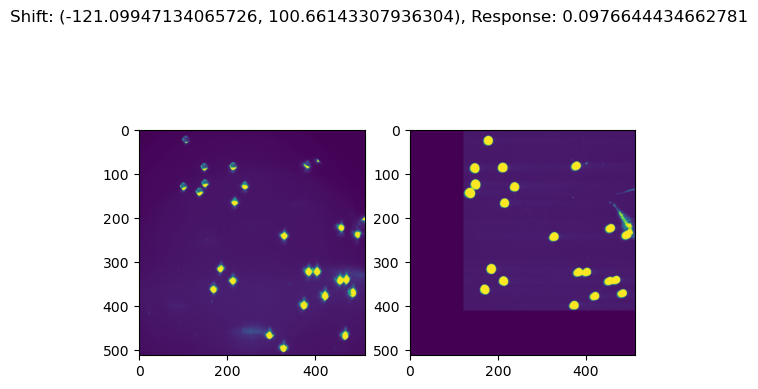

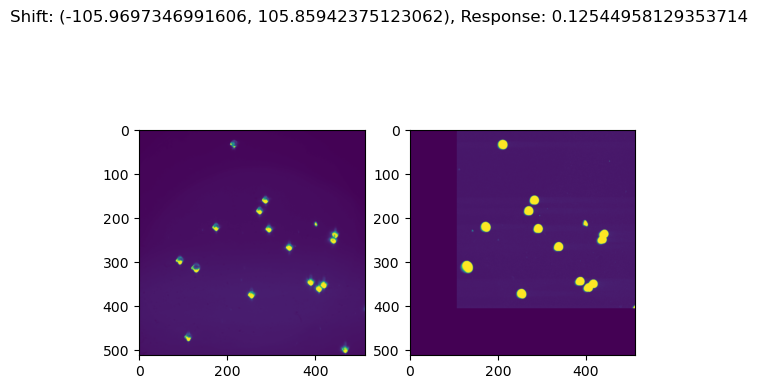

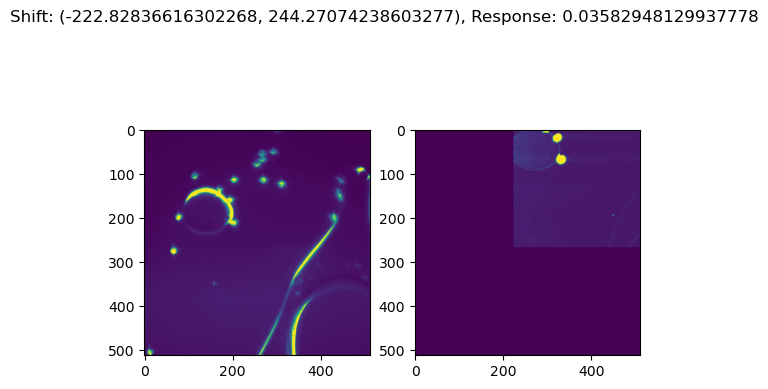

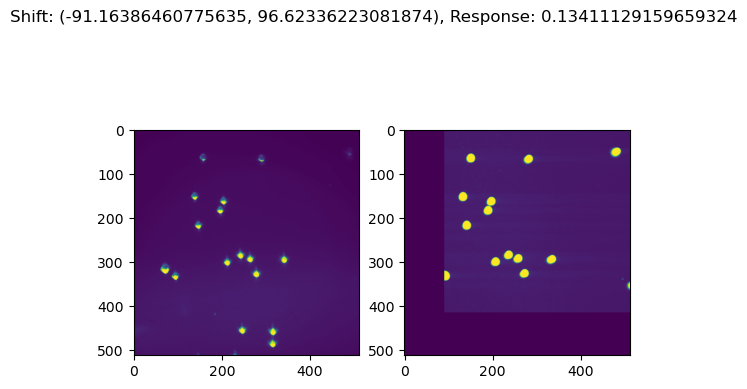

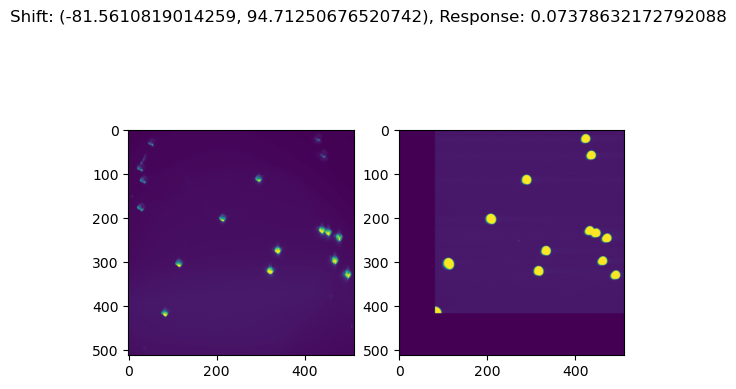

Avg: [-124.52450374  128.42549364], stdev: [50.94790973 58.04848538]
Avg response: 0.09336822387674143, stdev: 0.03578219208723872


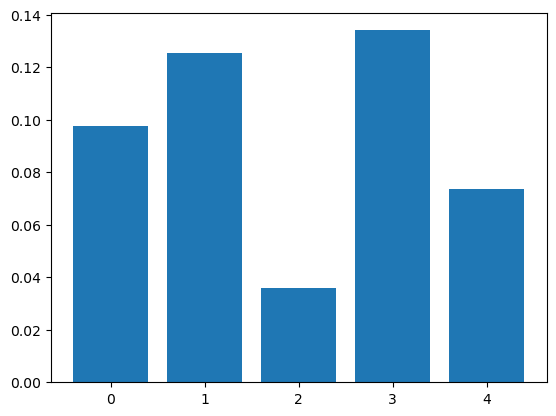

In [4]:
# Calculate the correction matrix for each image pair
T = []
R = []
for df_im, mpm_im in zip(df_images, mpm_images):
    df = convert_to_uint8(cv2.resize(cv2.imread(df_im, cv2.IMREAD_UNCHANGED), (512, 512), interpolation=cv2.INTER_CUBIC)).astype(np.float64)
    mpm = cv2.imread(mpm_im, cv2.IMREAD_UNCHANGED).astype(np.float64)
    shift, response = compute_rigid_transform(df, mpm)
    new_mpm = apply_transform(mpm, shift)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(df)
    axes[1].imshow(new_mpm)
    fig.suptitle(f'Shift: {shift}, Response: {response}')
    T.append(shift)
    R.append(response)
    plt.show()
print(f'Avg: {np.average(T, axis=0)}, stdev: {np.std(T, axis=0)}')
print(f'Avg response: {np.average(R, axis=0)}, stdev: {np.std(R, axis=0)}')
plt.bar([0, 1, 2, 3, 4], R)
plt.show()

Qualitatively -- by both the images and the response bars -- all the results seem good except the third image pair, so we will jsut throw it out and determine the average shift from the others. We can then use the third image pair as a test with this average transformation.

Default response for third image: 0.03582948129937778

Shift results with 3rd image dropped
Avg: [-99.94853814  99.46418146], stdev: [14.99071229  4.27145179]
Avg response: 0.10775290952108234, stdev: 0.023787826356721286


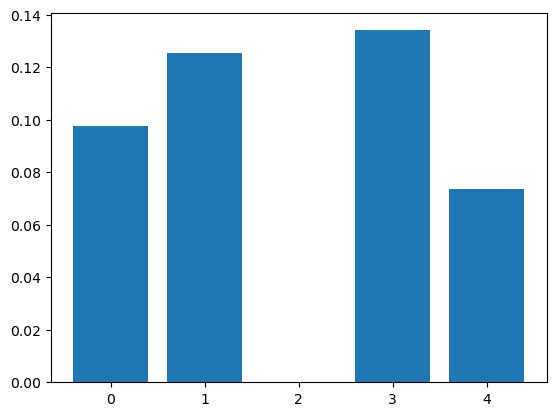

In [5]:
T.pop(2)
R3 = R.pop(2)
print(f'Default response for third image: {R3}')
print('\nShift results with 3rd image dropped')
avg_shift = np.average(T, axis=0)
print(f'Avg: {avg_shift}, stdev: {np.std(T, axis=0)}')
print(f'Avg response: {np.average(R, axis=0)}, stdev: {np.std(R, axis=0)}')
plt.bar([0, 1, 3, 4], R)
plt.show()

This gives us notable improvement in the shift precision and slight improvement in response. It's not a surprise that response doesn't change much, since the output of phasecorrelate is chosen based on peak response, but in theory, this average shift should give a decently good response for image 3 anyways.

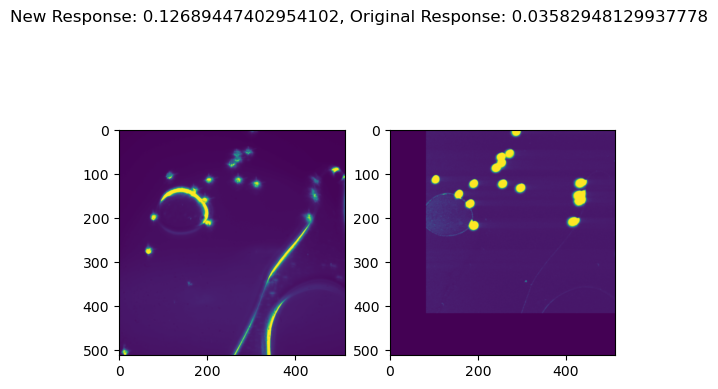

In [6]:
df = cv2.resize(cv2.imread(df_images[2], cv2.IMREAD_UNCHANGED).astype(np.float64), (512, 512), cv2.INTER_CUBIC)
mpm = cv2.imread(mpm_images[2], cv2.IMREAD_UNCHANGED).astype(np.float64)
new3 = apply_transform(mpm, shift)
response = cv2.matchTemplate(df.astype(np.float32), new3.astype(np.float32), cv2.TM_CCOEFF_NORMED)[0, 0]
fig, axes = plt.subplots(1, 2)
axes[0].imshow(df)
axes[1].imshow(new3)
fig.suptitle(f'New Response: {response}, Original Response: {R3}')
plt.show()

That's great. Huge improvement! Now let's run all the images with this shift and make sure they all respond well. If so, we are done. 

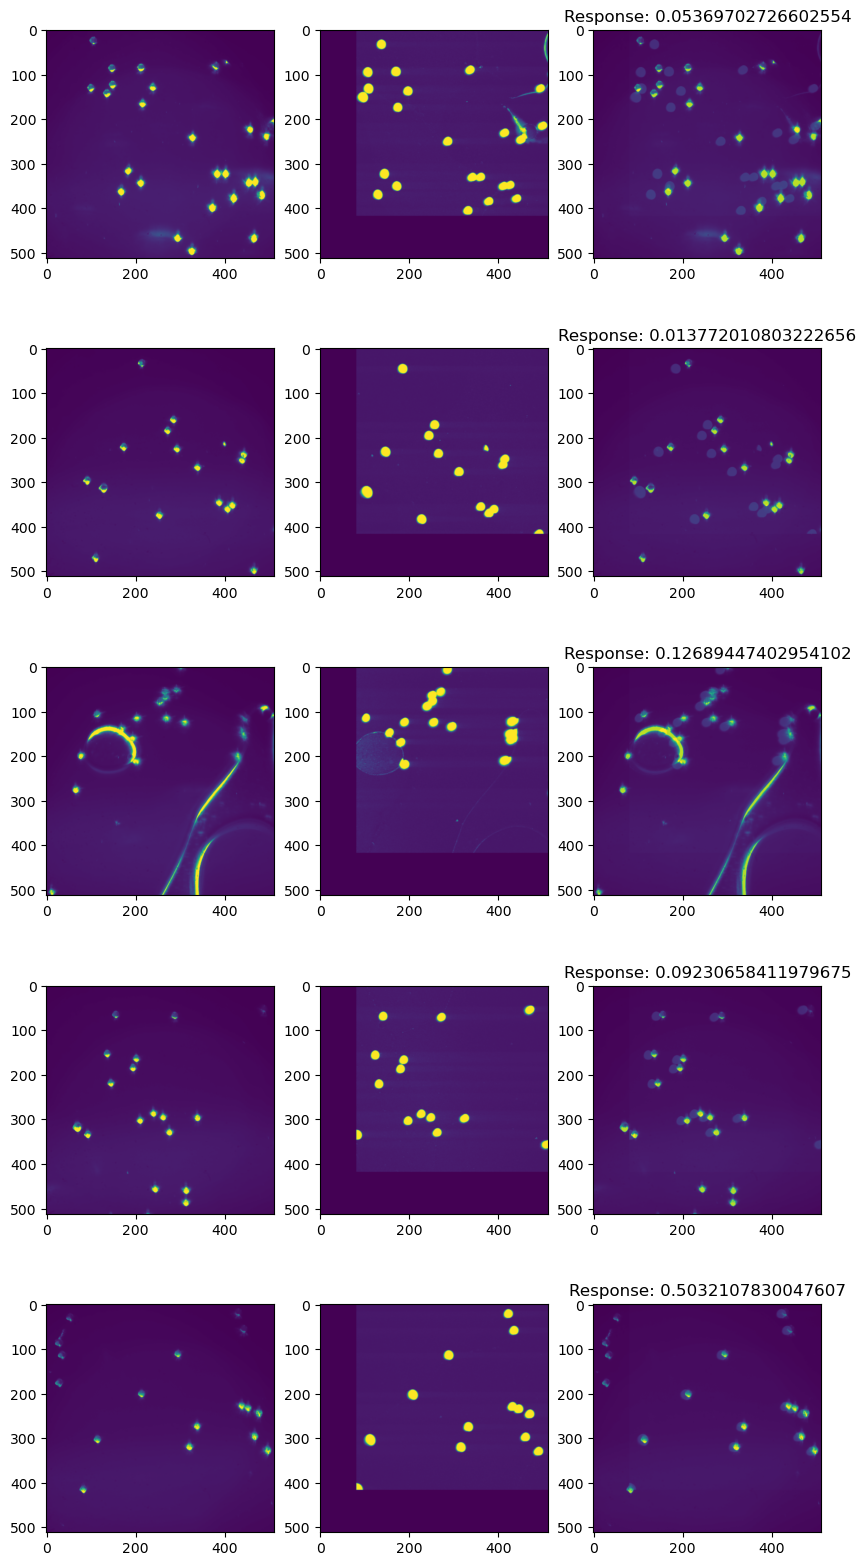

In [7]:
fig = plt.figure(figsize=[10, 20])
for i, (df_im, mpm_im) in enumerate(zip(df_images, mpm_images)):
    df = cv2.resize(cv2.imread(df_im, cv2.IMREAD_UNCHANGED).astype(np.float64), (512, 512), cv2.INTER_CUBIC)
    mpm = cv2.imread(mpm_im, cv2.IMREAD_UNCHANGED).astype(np.float64)
    new = apply_transform(mpm, shift)
    blended = cv2.addWeighted(df, 1, new, 1, 0)
    response = cv2.matchTemplate(df.astype(np.float32), new.astype(np.float32), cv2.TM_CCOEFF_NORMED)[0, 0]
    ax = fig.add_subplot(5, 3, 3*i+1)
    ax.imshow(df)
    ax = fig.add_subplot(5, 3, 3*i+2)
    ax.imshow(new)
    ax = fig.add_subplot(5, 3, 3*i+3)
    ax.imshow(blended)
    ax.set_title(f'Response: {response}')
plt.show()

Bummer...seems like the alginement was inconsistent. Interestingly, it looks like the offset moved in time (see below for x-shift across image pairs). I will re-iamge beads and see if we can get any consistency. If not, we will try to find a way to calibrate for each image, hopefully automatically, but at worst, by line ROI.

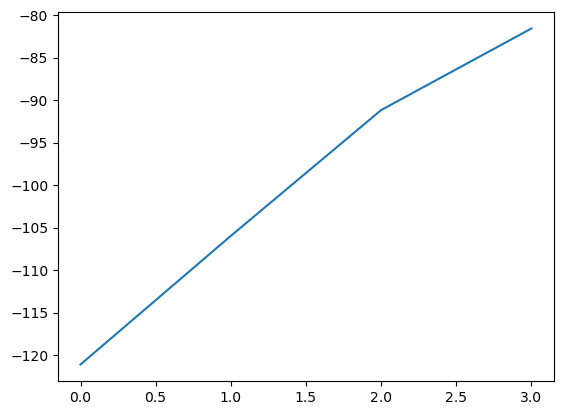

In [13]:
plt.plot([t[0] for t in T])
plt.show()